In [2]:
utility.print_versions()

Tensorflow version: 1.8.0
Keras version: 2.0.2


In [34]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import tensorflow as tf
import keras as keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint 
from keras.utils.np_utils import to_categorical
import math
import utility

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

This is an alternative to Step 5 in the project where transfer learning is used to create a CNN that can identify dog breed from images.  The CNN must attain at least 60% accuracy on the test set.

### High Level Approach

The high level approach is as follows:

1. Extract the bottleneck features from the InceptionV3 model
2. Train a new network using the extracted bottleneck features and save the model
3. Use both the InceptionV3 model and the new model to make predictions

To mitigate against overfitting image augmentation will be used to train the new network.

#### Extract Bottleneck Features from InceptionV3 Model

Extract bottleneck features by running augmented images through InceptionV3 with the final fully-connected layers removed.

The following is required to address a bug when using ImageDataGenerator and the InceptionV3 model. See [IOError: Image File is truncated](https://github.com/keras-team/keras/issues/5475) for details.

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Get the InceptionV3 model with the final fully-connected layers removed.

In [25]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(include_top=False)
#model.summary()

In [19]:
augment_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

#### Extract Bottleneck Features for Training

Use a data generator to run augmented images from the training dataset through the network.

In [20]:
train_generator = augment_datagen.flow_from_directory(
        'dogImages/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_train_samples = len(train_generator.filenames)
number_of_train_classes = len(train_generator.class_indices)
number_of_train_steps = int(math.ceil(number_of_train_samples / float(batch_size)))

train_bottleneck_features = model.predict_generator(train_generator, number_of_train_steps)

Found 6680 images belonging to 133 classes.


#### Extract Bottleneck Features for Validation

Use a data generator to run augmented images from the validation dataset through the network.

In [21]:
valid_generator = augment_datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_valid_samples = len(valid_generator.filenames)
number_of_valid_classes = len(valid_generator.class_indices)
number_of_valid_steps = int(math.ceil(number_of_valid_samples / float(batch_size)))

valid_bottleneck_features = model.predict_generator(valid_generator, number_of_valid_steps)

Found 835 images belonging to 133 classes.


#### Extract Bottleneck Features for Testing

Use a data generator to run non-augmented images from the testing dataset through the network.

In [22]:
test_generator = test_datagen.flow_from_directory(
        'dogImages/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_test_samples = len(test_generator.filenames)
number_of_test_classes = len(test_generator.class_indices)
number_of_test_steps = int(math.ceil(number_of_test_samples / float(batch_size)))

test_bottleneck_features = model.predict_generator(test_generator, number_of_test_steps)

Found 836 images belonging to 133 classes.


#### Save Bottleneck Features

Save the bottleneck features to an .npz file


In [24]:
np.savez('bottleneck_features/dog_features_augmented_InceptionV3Data.npz', train=train_bottleneck_features, valid=valid_bottleneck_features, test=test_bottleneck_features)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
1. Model was overfitting as training accuracy was higher than validation accuracy.
2. Reduce architecture complexity
3. Add regularization
4. Use data augmentation
5. Start with a low dropout in the first layer and then gradually increase


In [27]:
### Define your architecture.
InceptionV3_model = Sequential()
InceptionV3_model.add(Conv2D(filters=96, kernel_size=2, strides=1, padding='valid', input_shape=train_InceptionV3.shape[1:], activation='relu'))
InceptionV3_model.add(BatchNormalization(axis=1))
InceptionV3_model.add(Dropout(0.3))
InceptionV3_model.add(GlobalAveragePooling2D())
InceptionV3_model.add(Dropout(0.4))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_659 (Conv2D)          (None, 4, 4, 96)          786528    
_________________________________________________________________
batch_normalization_659 (Bat (None, 4, 4, 96)          16        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 96)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 96)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               12901     
Total params: 799,445.0
Trainable params: 799,437.0
Non-trainable par

### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [32]:
# load the bottleneck features
bottleneck_features = np.load('bottleneck_features/dog_features_augmented_InceptionV3Data.npz')

In [44]:
test_generator = augment_datagen.flow_from_directory(
        'dogImages/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

number_of_train_samples = len(test_generator.filenames)
number_of_train_classes = len(test_generator.class_indices)
number_of_train_steps = int(math.ceil(number_of_train_samples / float(batch_size)))

# get the bottleneck features
train_data = bottleneck_features['train']

# get class lables
train_labels = test_generator.classes

# convert to categorical vectors
train_labels = to_categorical(train_labels, num_classes=number_of_train_classes)

Found 6680 images belonging to 133 classes.


In [45]:
valid_generator = augment_datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_valid_samples = len(valid_generator.filenames)
number_of_valid_classes = len(valid_generator.class_indices)
number_of_valid_steps = int(math.ceil(number_of_valid_samples / float(batch_size)))

# get the bottleneck features
valid_data = bottleneck_features['valid']

# get class lables
valid_labels = valid_generator.classes

# convert to categorical vectors
valid_labels = to_categorical(valid_labels, num_classes=number_of_valid_classes)

Found 835 images belonging to 133 classes.


In [46]:
test_generator = test_datagen.flow_from_directory(
        'dogImages/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_test_samples = len(test_generator.filenames)
number_of_test_classes = len(test_generator.class_indices)
number_of_test_steps = int(math.ceil(number_of_test_samples / float(batch_size)))

# get the bottleneck features
test_data = bottleneck_features['test']

# get class lables
test_labels = test_generator.classes

# convert to categorical vectors
test_labels = to_categorical(test_labels, num_classes=number_of_test_classes)

Found 836 images belonging to 133 classes.


In [47]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', verbose=1, save_best_only=True)

history = InceptionV3_model.fit(train_data, train_labels, 
          validation_data=(valid_data, valid_labels),
          epochs=10, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 2s - loss: 0.4842 - acc: 0.8569 - val_loss: 0.6781 - val_acc: 0.8084
Epoch 2/10
6680/6680 [==============================] - 2s - loss: 0.4409 - acc: 0.8635 - val_loss: 0.7235 - val_acc: 0.8000
Epoch 3/10
6680/6680 [==============================] - 2s - loss: 0.3850 - acc: 0.8810 - val_loss: 0.6968 - val_acc: 0.8132
Epoch 4/10
6680/6680 [==============================] - 2s - loss: 0.3594 - acc: 0.8852 - val_loss: 0.7276 - val_acc: 0.7904
Epoch 5/10
6680/6680 [==============================] - 2s - loss: 0.3372 - acc: 0.8969 - val_loss: 0.6649 - val_acc: 0.8216
Epoch 6/10
6680/6680 [==============================] - 2s - loss: 0.3106 - acc: 0.9027 - val_loss: 0.7509 - val_acc: 0.8012
Epoch 7/10
6680/6680 [==============================] - 2s - loss: 0.2806 - acc: 0.9126 - val_loss: 0.7370 - val_acc: 0.8000
Epoch 8/10
6680/6680 [==============================] - 2s - loss: 0.2716 - ac

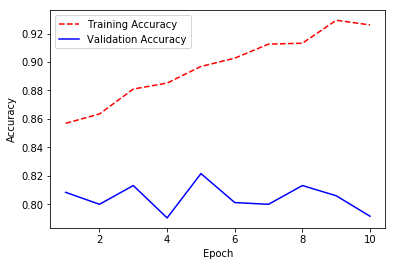

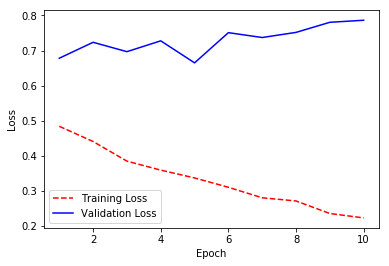

In [48]:
utility.plot_accuracy(history)
utility.plot_loss(history)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [49]:
### Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [50]:
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_data]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_labels, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.1340%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### Returns the dog breed that is predicted by the model.
def InceptionV3_predict_breed(img_path): 
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
def predict_dog_breed_from_human_or_dog(img_path):
    image_type = "error"
    dog_breed = "N/A"
    
    if face_detector(img_path):
        image_type = "face"
        dog_breed = InceptionV3_predict_breed(img_path)
    elif dog_detector(img_path):
        image_type = "dog"
        dog_breed = InceptionV3_predict_breed(img_path)
    
    return image_type, dog_breed

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import matplotlib.image as mpimg                     
%matplotlib inline 

def show_image(img_path):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.show()
    
def test_algorithm(img_path):
    print("\nProcessing: {}".format(img_path))
    show_image(img_path)
    
    image_type, dog_breed = predict_dog_breed_from_human_or_dog(img_path)

    if image_type is "face":       
        print("This human looks like a {}".format(dog_breed))
    elif image_type is "dog":
        print("This dog looks like a {}".format(dog_breed))
    else:
        print("Error neither human or dog detected!")

In [ ]:
# load list of dog names
sample_images = glob("images/*")

for sample_image in sample_images:
    test_algorithm(sample_image)